# **TEXT SPAM CLASSIFIER **

In [87]:
import string

import pandas as pd
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import  PorterStemmer

from wordcloud import WordCloud

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import pickle

In [88]:
df_email = pd.read_csv(
    "/kaggle/input/datasets/venky73/spam-mails-dataset/spam_ham_dataset.csv"
)

df_email.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [89]:
df_email.columns

Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object')

In [90]:
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv',encoding='latin-1')

In [91]:
# Prepare data for email
df_email_clean = df_email[["label", "text"]].copy()
df_email_clean.columns = ["label", "text"]

In [92]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [93]:
# prepare sms data in same format
df_sms_clean = df[["v1", "v2"]].copy()
df_sms_clean.columns = ["label", "text"]

In [94]:
df_all = pd.concat(
    [df_sms_clean, df_email_clean],
    axis=0,
    ignore_index=True
)

In [95]:
df_all["label"] = df_all["label"].map({
    "ham": 0,
    "spam": 1
})

In [96]:
# Remove missing rows (safety)
df_all = df_all.dropna(subset=["text", "label"])


In [97]:
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)

In [98]:
df_all.head()

,label,text
0,0,Subject: fw : epgt\r\ndaren - can you please l...
1,0,Should i send you naughty pix? :)
2,0,Going to take your babe out ?
3,0,Subject: meter # : 6599\r\ndeal 138049 is comm...
4,1,Knock Knock Txt whose there to 80082 to enter ...


In [99]:
df = df_all.copy()

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10743 entries, 0 to 10742
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10743 non-null  int64 
 1   text    10743 non-null  object
dtypes: int64(1), object(1)
memory usage: 168.0+ KB


In [101]:
df = df.rename(columns={"label": "target"})

In [102]:
# To convert values into boolean
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [103]:
#Missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [104]:
# Check for duplicates
df.duplicated().sum()

np.int64(581)

In [105]:
# Remove duplicates
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

np.int64(0)

In [106]:
df.shape

(10162, 2)

# EDA

In [107]:
df['target'].value_counts()
# Ham is more than spam

target
0    8047
1    2115
Name: count, dtype: int64

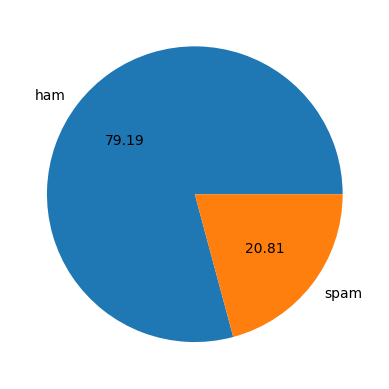

In [108]:
plt.pie(df['target'].value_counts(),labels=['ham','spam'],autopct="%0.2f")
plt.show()

# Conclusion - Data in imbalance

In [109]:
# Length of each message
df['num_characters'] = df['text'].apply(len)
df.head()

,target,text,num_characters
0,0,Subject: fw : epgt\r\ndaren - can you please l...,1594
1,0,Should i send you naughty pix? :),33
2,0,Going to take your babe out ?,29
3,0,Subject: meter # : 6599\r\ndeal 138049 is comm...,338
4,1,Knock Knock Txt whose there to 80082 to enter ...,156


In [110]:
# No. of words
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,target,text,num_characters,num_words
0,0,Subject: fw : epgt\r\ndaren - can you please l...,1594,376
1,0,Should i send you naughty pix? :),33,9
2,0,Going to take your babe out ?,29,7
3,0,Subject: meter # : 6599\r\ndeal 138049 is comm...,338,75
4,1,Knock Knock Txt whose there to 80082 to enter ...,156,31


In [111]:
# No. of sentences
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,Subject: fw : epgt\r\ndaren - can you please l...,1594,376,23
1,0,Should i send you naughty pix? :),33,9,2
2,0,Going to take your babe out ?,29,7,1
3,0,Subject: meter # : 6599\r\ndeal 138049 is comm...,338,75,4
4,1,Knock Knock Txt whose there to 80082 to enter ...,156,31,2


In [112]:
df.describe()

,target,num_characters,num_words,num_sentences
count,10162.000000,10162.000000,10162.000000,10162.000000
mean,0.208128,565.625172,124.203208,7.577347
std,0.405989,1193.312821,262.099908,20.438770
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,56.000000,14.000000,1.000000
50%,0.000000,143.000000,31.000000,3.000000
75%,0.000000,540.000000,122.000000,7.000000
max,1.000000,32258.000000,8863.000000,1204.000000


In [113]:
# describe for ham
df[df['target']==0][['target','num_characters','num_words','num_sentences']].describe()

,target,num_characters,num_words,num_sentences
count,8047.0,8047.000000,8047.000000,8047.000000
mean,0.0,476.118429,110.759662,6.138934
std,0.0,1037.113374,247.282194,17.504968
min,0.0,2.000000,1.000000,1.000000
25%,0.0,47.000000,12.000000,1.000000
50%,0.0,107.000000,26.000000,2.000000
75%,0.0,433.500000,104.000000,6.000000
max,0.0,32258.000000,8863.000000,1204.000000


In [114]:
# describe for apam
df[df['target']==1][['target','num_characters','num_words','num_sentences']].describe()

,target,num_characters,num_words,num_sentences
count,2115.0,2115.000000,2115.000000,2115.000000
mean,1.0,906.173995,175.352246,13.050118
std,0.0,1613.735247,306.840487,28.351146
min,1.0,11.000000,2.000000,1.000000
25%,1.0,150.000000,29.000000,3.000000
50%,1.0,331.000000,67.000000,5.000000
75%,1.0,863.500000,174.000000,13.000000
max,1.0,22073.000000,3963.000000,693.000000



> From above analysis we can clearly see that avg words of spam are 27 and ham are 17, characters also 137 and 27 respectively.Which means spam messages are lengthy


<Axes: xlabel='num_characters', ylabel='Count'>

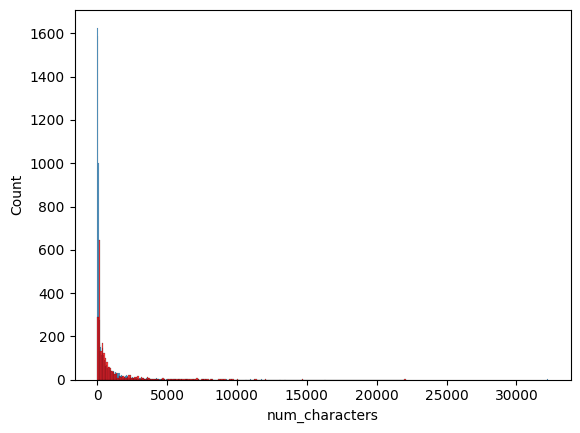

In [115]:
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

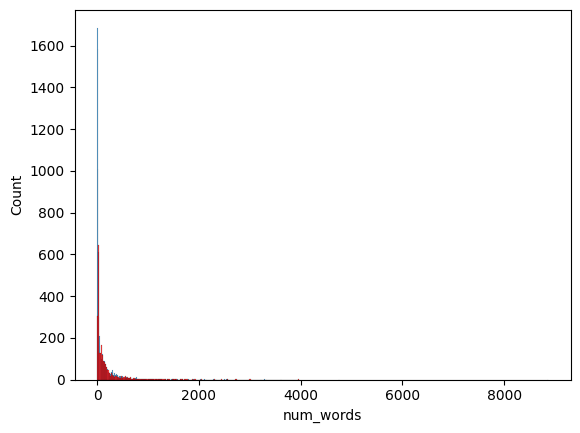

In [116]:
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'],color='red')

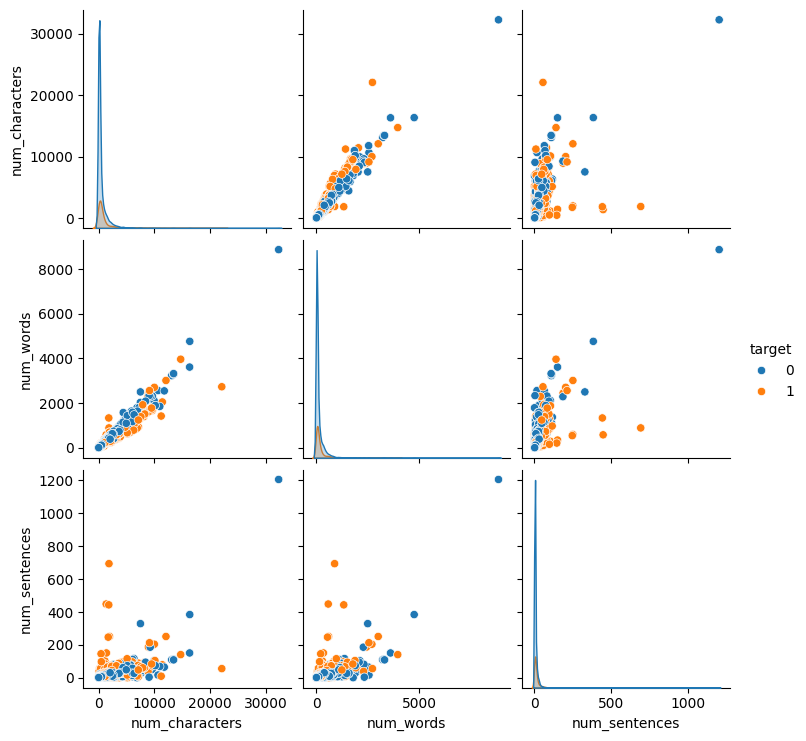

In [117]:
sns.pairplot(df,hue='target')

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10162 entries, 0 to 10742
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   target          10162 non-null  int64 
 1   text            10162 non-null  object
 2   num_characters  10162 non-null  int64 
 3   num_words       10162 non-null  int64 
 4   num_sentences   10162 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 476.3+ KB


<Axes: >

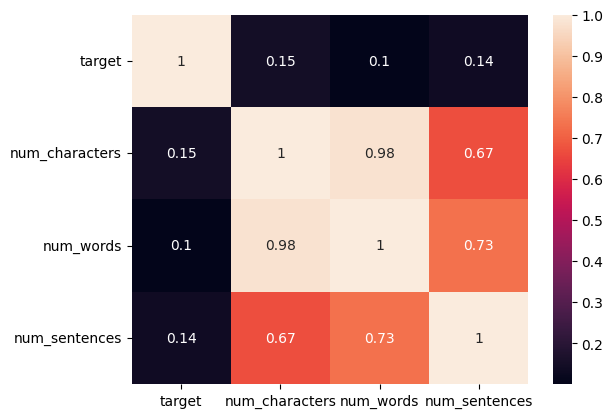

In [119]:
# Can only apply on nnumber fields
num_df = df.select_dtypes(include="number")

num_df.corr()

sns.heatmap(num_df.corr(),annot=True)

> Variation of num_characters with target is highest so we can use to create a model

# Data Preprocessing

In [120]:
ps = PorterStemmer()
ps.stem("Loving")

'love'

In [121]:
def transform_text(text):
    # Convert in lowercase
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    # Use set below to avoid nested loops
    stop_words = set(stopwords.words("english"))

    y = []
    for t in tokens:
        # if special chars then don't append
        # if t.isalnum() and t not in stopwords.words('english') and t not in string.punctuation:
        # if t.isalnum() and t not in stopwords.words('english'): # no need of string.punctuation
        if t.isalnum() and t not in stop_words: # no need to stopwords list
            y.append(ps.stem(t))
        
    return " ".join(y)


In [122]:
text = "How was your yesterday's meeting? was that good?"
transform_text(text)

'yesterday meet good'

In [123]:
text = "How was your meeting bro?"
transform_text(text)

'meet bro'

In [124]:
# remove stop words
stopwords.words('english')

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [125]:
# punctuation marks
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [126]:
df['transformed_text'] = df['text'].apply((transform_text))

In [127]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,Subject: fw : epgt\r\ndaren - can you please l...,1594,376,23,subject fw epgt daren pleas let know statu 02 ...
1,0,Should i send you naughty pix? :),33,9,2,send naughti pix
2,0,Going to take your babe out ?,29,7,1,go take babe
3,0,Subject: meter # : 6599\r\ndeal 138049 is comm...,338,75,4,subject meter 6599 deal 138049 commit reserv l...
4,1,Knock Knock Txt whose there to 80082 to enter ...,156,31,2,knock knock txt whose 80082 enter r weekli dra...


In [128]:
# To hhighlight the important words
wc = WordCloud(width=1000,height=1000,min_font_size=10,background_color='white')

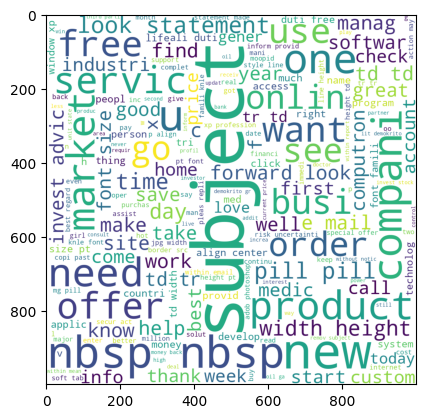

In [129]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.imshow(spam_wc)

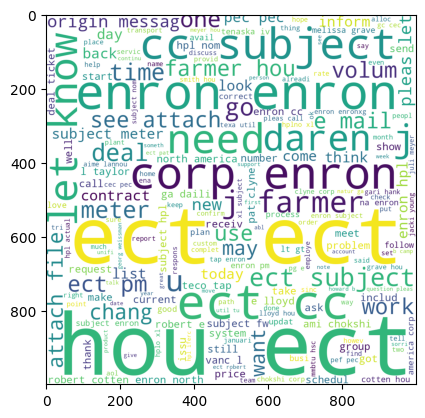

In [130]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.imshow(ham_wc)

In [131]:
# All data in one list
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
len(spam_corpus)

206531

In [132]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)
len(ham_corpus)

415879

**Top spam words chart**

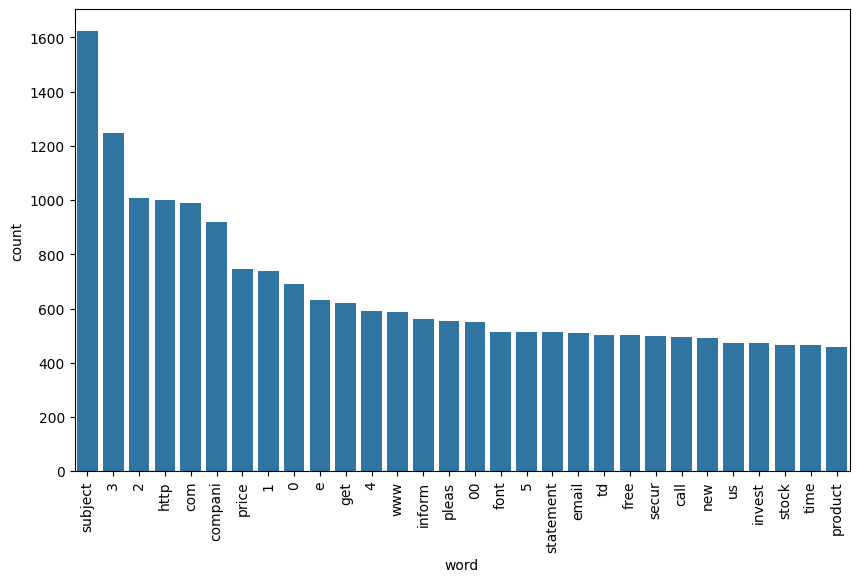

In [133]:
top30Spam = pd.DataFrame(
    Counter(spam_corpus).most_common(30),
    columns=["word", "count"]
)

plt.figure(figsize=(10,6))
sns.barplot(data=top30Spam, x="word", y="count")
plt.xticks(rotation=90)
plt.show()

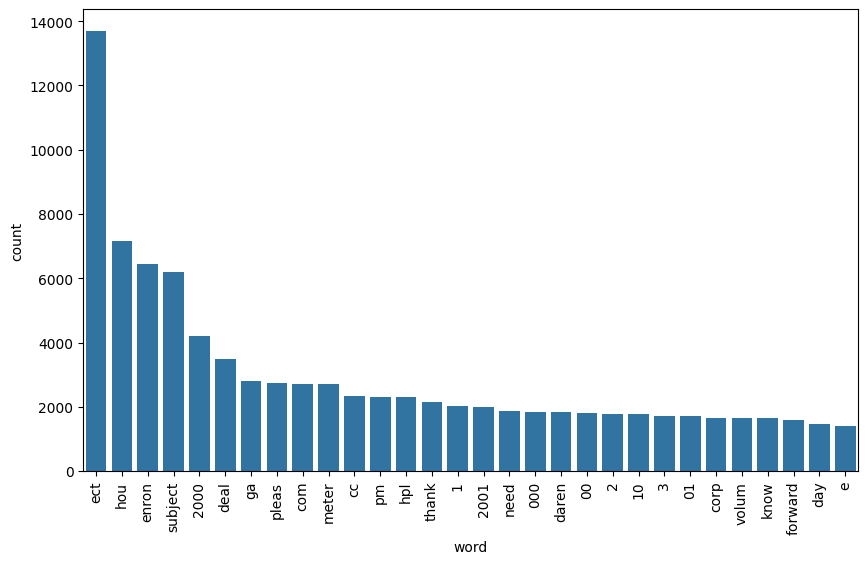

In [134]:
top30Ham = pd.DataFrame(
    Counter(ham_corpus).most_common(30),
    columns=["word", "count"]
)

plt.figure(figsize=(10,6))
sns.barplot(data=top30Ham, x="word", y="count")
plt.xticks(rotation=90)
plt.show()

# Building Model

# 1.Naive Bayes

In [135]:
# # cv = CountVectorizer()
# # tfidf = TfidfVectorizer()
# tfidf = TfidfVectorizer(max_features=3000)
# # Features
# X = tfidf.fit_transform(df['transformed_text']).toarray()

In [136]:
# Replaced above step with this to avoid words trimming
tfidf = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(3, 5),
    min_df=2
)
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [137]:
scalar = MinMaxScaler()
X = scalar.fit_transform(X)

In [138]:
# Target
y = df['target'].values

In [139]:
X.shape

(10162, 104769)

In [140]:
y.shape

(10162,)

In [141]:
# Random split
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
# stratified split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2,stratify=y)

> precision_score of BernoulliNB was 97 with random split and 98 with stratified split

In [142]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [143]:
# Create Gaussian model
gnb.fit(X_train,y_train)

GaussianNB()

In [144]:
y_pred1 = gnb.predict(X_test)
print(f"accuracy_score -- {accuracy_score(y_test,y_pred1)}")
print(f"confusion_matrix--{confusion_matrix(y_test,y_pred1)}")
print(f"precision_score -- {precision_score(y_test,y_pred1)}")

accuracy_score -- 0.868175110673881
confusion_matrix--[[1375  235]
 [  33  390]]
precision_score -- 0.624


In [145]:
# Create Multinomial model
mnb.fit(X_train,y_train)

MultinomialNB()

In [146]:
y_pred2 = mnb.predict(X_test)
print(f"accuracy_score -- {accuracy_score(y_test,y_pred2)}")
print(f"confusion_matrix--{confusion_matrix(y_test,y_pred2)}")
print(f"precision_score -- {precision_score(y_test,y_pred2)}")

accuracy_score -- 0.9591736350221348
confusion_matrix--[[1569   41]
 [  42  381]]
precision_score -- 0.9028436018957346


> mnb precision was 87 with countervectorizer but 1 with tfidf so we will keep tfidf mnb

precision_score -- 1.0

> mnb accuracy was 96 with tfidf all features but now 98 with tfidf 3k features so we will keep tfidf max features 3k

accuracy_score -- 0.9825918762088974

> mnb accuracy improved after scaling

accuracy_score -- 0.988394584139265


In [147]:
# Create Burnauli model
bnb.fit(X_train,y_train)

BernoulliNB()

In [148]:
y_pred3 = bnb.predict(X_test)
print(f"accuracy_score -- {accuracy_score(y_test,y_pred3)}")
print(f"confusion_matrix--{confusion_matrix(y_test,y_pred3)}")
print(f"precision_score -- {precision_score(y_test,y_pred3)}")

accuracy_score -- 0.8425971470732907
confusion_matrix--[[1516   94]
 [ 226  197]]
precision_score -- 0.6769759450171822


In [150]:

pickle.dump(tfidf,open('vectorizer2.pkl','wb'))
pickle.dump(mnb,open('model2.pkl','wb'))